# Testing LOSD
### Bevölkerung nach Stadtquartier, seit 1941

Wirtschaftliche Wohnbevölkerung der Stadt Zürich nach Statistischem Stadtquartier und Jahr, seit 1941.
https://data.integ.stadt-zuerich.ch/dataset/bev324od3240 

Datum: 12.02.2024

### Colab
Mit Colab kann das Jupyter-Notebook interaktiv im Browser gestartet werden. 

Klicke auf den Button:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DonGoginho/colab/blob/main/losd/3240_losd_bev_bestand_jahr_quartier_od3240.ipynb)


### Importiere die notwendigen Packages

In [1]:
#%pip install altair datetime folium geopandas io requests matplotlib numpy pandas seaborn plotly

In [2]:
import altair as alt
import datetime
import folium 
import geopandas as gpd
import io
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pivottablejs
#from pivottablejs import pivot_ui
import plotly.express as px
import requests
import seaborn as sns

Importiere die eigenen Funktionen, die unter ../0_scripts abegelegt sind:

In [3]:
import sys
sys.path.append('../0_scripts')

import my_py_dataviz_functions as mypy_dv
import my_py_dataloading_functions as mypy_dl

In [4]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [5]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

### Settings
Definiere Settings. 
Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen)

In [6]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

#### Zeitvariabeln

In [7]:
#Zeitvariabeln als Strings:
now = datetime.date.today()
year_today = now.strftime("%Y")
date_today = "_"+now.strftime("%Y-%m-%d")

#Zeitvariabeln als Integers:
int_times = now.timetuple()
aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2
#print(aktuellesJahr, aktuellerMonat,'datenstand: ', selectedMonat, int_times)

### Daten importieren und Metadaten checken

- status: int / prod
- data_source: web / ld / dropzone
- datums_attr: beschreibt das oder die Datumsfelder, die als Datum geparsed werden sollen. Falls es keines gibt: None

**BITTE HIER ANPASSEN**

In [8]:
package_name = "bev324od3240"

In [9]:
data2betested = mypy_dl.load_data(
    status = 'int'
    , data_source = 'ld'
    , package_name = package_name
    , dataset_name = "bev324od3240.csv"    
    , datums_attr = ['ZEIT_LANG']
    )

fp lautet:https://ld.integ.stadt-zuerich.ch/statistics/view/BEV324OD3240/observation?format=csv


 **Überprüfe die Metadaten:**

 **Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/bev324od3240 

 **View auf INTEG-LD:** Link https://ld.integ.stadt-zuerich.ch/statistics/view/BEV324OD3240 

data_source: web


In [10]:
data2betested.head(2)

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEW,Datenstatus,KREISEZH_LANG,KREISEZH_CODE
0,1954-12-31,Z31121954,Oerlikon,R00115,21172,Definitiv,Kreis 11 (ab 1970),R01800
1,1956-12-31,Z31121956,Mühlebach,R00082,8707,Definitiv,Kreis 8 (ab 1915),R01100


Berechne weitere Attribute falls notwendig

In [11]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr = lambda x: x.ZEIT_LANG,
        StichtagDatJahr_str = lambda x: x.ZEIT_LANG.astype(str),
        Jahr = lambda x: x.ZEIT_LANG.dt.year,
        #Jahr_nbr = lambda x: x.ZEIT_CODE.str[-4:].astype(int),    
        RAUM_my_sort = lambda x: x.RAUM_CODE.str[-3:].astype(int),

    )
    .sort_values('ZEIT_LANG', ascending=False)
    )
data2betested

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEW,Datenstatus,KREISEZH_LANG,KREISEZH_CODE,StichtagDatJahr,StichtagDatJahr_str,Jahr,RAUM_my_sort
1973,2023-12-31,Z31122023,Weinegg,R00083,5589,Provisorisch,Kreis 8 (ab 1915),R01100,2023-12-31,2023-12-31,2023,83
237,2023-12-31,Z31122023,Langstrasse,R00042,11982,Provisorisch,Kreis 4 (ab 1915),R00700,2023-12-31,2023-12-31,2023,42
1388,2023-12-31,Z31122023,Lindenhof,R00013,1046,Provisorisch,Kreis 1 (Stadtgebiet vor 1893),R10000,2023-12-31,2023-12-31,2023,13
348,2023-12-31,Z31122023,Leimbach,R00023,6423,Provisorisch,Kreis 2 (ab 1893),R00200,2023-12-31,2023-12-31,2023,23
2323,2023-12-31,Z31122023,Mühlebach,R00082,6494,Provisorisch,Kreis 8 (ab 1915),R01100,2023-12-31,2023-12-31,2023,82
...,...,...,...,...,...,...,...,...,...,...,...,...
698,1894-12-31,Z31121894,Langstrasse,R00042,17309,Definitiv,Kreis 4 (ab 1915),R00700,1894-12-31,1894-12-31,1894,42
2186,1894-12-31,Z31121894,Escher Wyss,R00052,584,Definitiv,Kreis 5 (ab 1915),R00800,1894-12-31,1894-12-31,1894,52
1400,1894-12-31,Z31121894,City,R00014,5479,Definitiv,Kreis 1 (Stadtgebiet vor 1893),R10000,1894-12-31,1894-12-31,1894,14
1095,1894-12-31,Z31121894,Hottingen,R00072,8375,Definitiv,Kreis 7 (ab 1934),R01300,1894-12-31,1894-12-31,1894,72


Zeitbereich aus den Daten:

In [12]:
data_max_date = str(max(data2betested.ZEIT_LANG).year)
data_min_date = str(min(data2betested.ZEIT_LANG).year)

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")


Die Daten haben ein Minimumjahr von 1894 und ein Maximumjahr von 2023


Temp speichere die csv-Datei, da es immer wieder zu Ausfällen kommt. So kann ich mal den Report fertig bauen.

In [13]:
docname = package_name +date_today+".csv"
print(docname)


bev324od3240_2024-06-26.csv


In [14]:
data2betested.to_csv('./saved_data/'+docname, index=False)

### Einfache Datentests

In [15]:
data2betested.head(2).T

,1973,237
ZEIT_LANG,2023-12-31 00:00:00,2023-12-31 00:00:00
ZEIT_CODE,Z31122023,Z31122023
RAUM_LANG,Weinegg,Langstrasse
RAUM_CODE,R00083,R00042
BEW,5589,11982
Datenstatus,Provisorisch,Provisorisch
KREISEZH_LANG,Kreis 8 (ab 1915),Kreis 4 (ab 1915)
KREISEZH_CODE,R01100,R00700
StichtagDatJahr,2023-12-31 00:00:00,2023-12-31 00:00:00
StichtagDatJahr_str,2023-12-31,2023-12-31


In [16]:
data2betested.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2809 entries, 1973 to 961
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ZEIT_LANG            2809 non-null   datetime64[ns]
 1   ZEIT_CODE            2809 non-null   object        
 2   RAUM_LANG            2809 non-null   object        
 3   RAUM_CODE            2809 non-null   object        
 4   BEW                  2809 non-null   float64       
 5   Datenstatus          2809 non-null   object        
 6   KREISEZH_LANG        2809 non-null   object        
 7   KREISEZH_CODE        2809 non-null   object        
 8   StichtagDatJahr      2809 non-null   datetime64[ns]
 9   StichtagDatJahr_str  2809 non-null   object        
 10  Jahr                 2809 non-null   int32         
 11  RAUM_my_sort         2809 non-null   int32         
dtypes: datetime64[ns](2), float64(1), int32(2), object(7)
memory usage: 1.4 MB


In [17]:
print(f'The dataset has {data2betested.shape[0]:,.0f} rows (observations) and {data2betested.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {data2betested.duplicated().sum()} exact duplicates in the data.')

The dataset has 2,809 rows (observations) and 12 columns (variables).
There seem to be 0 exact duplicates in the data.


Welches sind die Quartiere ohne Werte bei BEW?

In [18]:
data2betested[np.isnan(data2betested.BEW)]

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEW,Datenstatus,KREISEZH_LANG,KREISEZH_CODE,StichtagDatJahr,StichtagDatJahr_str,Jahr,RAUM_my_sort


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [19]:
data2betested = data2betested.set_index("StichtagDatJahr") 
data2betested = data2betested.sort_index()

In [20]:
data2betested.index.year.unique()

Index([1894, 1900, 1910, 1920, 1930, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype='int32', name='StichtagDatJahr')

### Beschreibe einzelne Attribute

Beschreibe nicht numerische Attribute

In [21]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(data2betested.describe(exclude='number',datetime_is_numeric=True))
except:
    print("No categorical data in dataset.")

No categorical data in dataset.


Beschreibe numerische Attribute

In [22]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data2betested.describe(include='number'))
except:
    print("No numercial data in dataset.")

,BEW,Jahr,RAUM_my_sort
count,"2,809","2,809","2,809"
mean,"11,506","1,981",63
std,"7,238",27,35
min,412,"1,894",11
25%,"5,790","1,961",33
50%,"10,326","1,982",63
75%,"16,658","2,003",91
max,"36,315","2,023",123


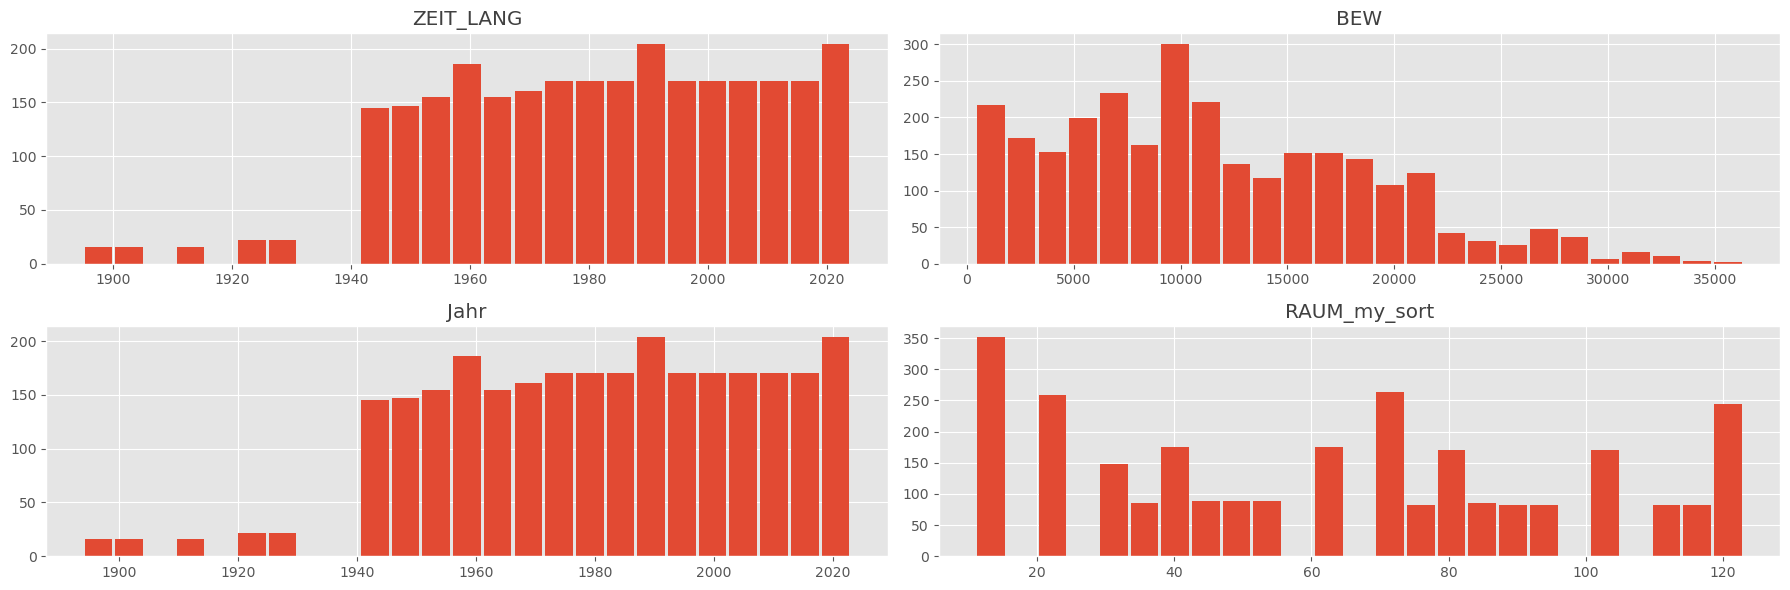

In [23]:
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

try:
    data2betested.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Gibt es Duplikate?

In [24]:
# find duplicate rows
duplicate_rows = data2betested[data2betested.duplicated()]
duplicate_rows

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEW,Datenstatus,KREISEZH_LANG,KREISEZH_CODE,StichtagDatJahr_str,Jahr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,,


### Nullwerte und Missings?

In [25]:
data2betested.isnull().sum()

ZEIT_LANG              0
ZEIT_CODE              0
RAUM_LANG              0
RAUM_CODE              0
BEW                    0
Datenstatus            0
KREISEZH_LANG          0
KREISEZH_CODE          0
StichtagDatJahr_str    0
Jahr                   0
RAUM_my_sort           0
dtype: int64

In [26]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
import missingno as msno
#msno.matrix(data2betested, labels=True, sort='descending');
#msno.heatmap(data2betested)

### Gruppierungen

In [27]:
agg_jahr = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('Jahr', ascending=False) 
agg_jahr.reset_index().head(3)

,Jahr,sum_AnzBestWir
0,2023,447082
1,2022,443037
2,2021,436332


In [28]:
agg_Quarts = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['RAUM_my_sort', 'RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('RAUM_CODE', ascending=False) 
agg_Quarts.reset_index().head(50)

,RAUM_my_sort,RAUM_LANG,RAUM_CODE,sum_AnzBestWir
0,123,Hirzenbach,R00123,636170
1,122,Schwamendingen-Mitte,R00122,585323
2,121,Saatlen,R00121,381872
3,119,Seebach,R00119,1510695
4,115,Oerlikon,R00115,1602590
5,111,Affoltern,R00111,1401886
6,102,Wipkingen,R00102,1547932
7,101,Höngg,R00101,1435583
8,92,Altstetten,R00092,2191484
9,91,Albisrieden,R00091,1410498


In [29]:
agg_Quarts = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Datenstatus', 'ZEIT_LANG', 'ZEIT_CODE',]) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('ZEIT_CODE', ascending=False) 
agg_Quarts.reset_index().head(50)

,Datenstatus,ZEIT_LANG,ZEIT_CODE,sum_AnzBestWir
0,Provisorisch,2023-12-31,Z31122023,447082
1,Veröffentlicht,2022-12-31,Z31122022,443037
2,Veröffentlicht,2021-12-31,Z31122021,436332
3,Veröffentlicht,2020-12-31,Z31122020,434736
4,Veröffentlicht,2019-12-31,Z31122019,434008
5,Veröffentlicht,2018-12-31,Z31122018,428737
6,Definitiv,2017-12-31,Z31122017,423310
7,Definitiv,2016-12-31,Z31122016,415682
8,Definitiv,2015-12-31,Z31122015,410404
9,Definitiv,2014-12-31,Z31122014,404783


In [30]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'BEW', 'Datenstatus', 'KREISEZH_LANG',
       'KREISEZH_CODE', 'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [31]:
data2betested.loc[data_max_date].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,BEW,Datenstatus,KREISEZH_LANG,KREISEZH_CODE,StichtagDatJahr_str,Jahr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,,
2023-12-31,2023-12-31,Z31122023,Wollishofen,R00021,21181,Provisorisch,Kreis 2 (ab 1893),R00200,2023-12-31,2023,21
2023-12-31,2023-12-31,Z31122023,Werd,R00041,4650,Provisorisch,Kreis 4 (ab 1915),R00700,2023-12-31,2023,41


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnbevölkerung seit ...

In [32]:
myAgg1 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr','Datenstatus']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 

myAgg1.reset_index().tail(4)

,StichtagDatJahr,Datenstatus,sum_WBev
85,1920-12-31,Definitiv,195367
86,1910-12-31,Definitiv,132389
87,1900-12-31,Definitiv,106139
88,1894-12-31,Definitiv,91032


In [33]:
grafik1 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg1.reset_index().query('sum_WBev>30')
    , x = 'StichtagDatJahr:T'
    , y = 'sum_WBev:Q'
    , myTitle = "Bevölkerungsentwicklung seit "+str(data2betested.index.year.min())
    , x_beschriftung = 'Jahr'
    , y_beschriftung = 'Anz. Personen'
    , warning_status  = "ignore"
    , category='Datenstatus'
    , category_beschriftung='Datenstatus'
)
grafik1

alt.LayerChart(...)

In [34]:
grafic_name = package_name+"_alt1_total"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik1.save('grafiken_testing/'+grafic_name)

grafiken_testing/bev324od3240_alt1_total_2024-06-26.png


#### Entwicklung Wohnbevölkerung nach Stadtquartier seit 1894

In [35]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'BEW', 'Datenstatus', 'KREISEZH_LANG',
       'KREISEZH_CODE', 'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [36]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg2 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg2.reset_index().head(3)

,StichtagDatJahr,RAUM_LANG,RAUM_CODE,sum_WBev
0,1894-12-31,City,R00014,5479
1,1894-12-31,Wollishofen,R00021,2413
2,1894-12-31,Wipkingen,R00102,3432


In [37]:
#data = myAgg2.loc['1993':data_max_date].reset_index().query('sum_WBev>30')

grafik2 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg2.loc[data_min_date:data_max_date].reset_index().query('sum_WBev>30')
    ,x = 'StichtagDatJahr:T'
    ,x_beschriftung = 'Jahr'
    ,y = 'sum_WBev:Q'
    ,y_beschriftung = 'Anz. Personen'
    ,category = "RAUM_LANG"
    ,category_beschriftung= 'Stadtquartier'
    ,warning_status = "ignore" #always or ignore
    ,myTitle="Bevölkerung nach Stadtquartier, seit "+str(data2betested.index.year.min())
)   
grafik2 

alt.LayerChart(...)

In [38]:
grafic_name = package_name+"_alt2_raum_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik2.save('grafiken_testing/'+grafic_name)

grafiken_testing/bev324od3240_alt2_raum_zeit_2024-06-26.png


#### Entwicklung Wohnbevölkerung nach Stadtquartier der Kreise 10-12, 1941-1981

In [39]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg3 = data2betested.loc["1890":"1981"]\
    .groupby(['StichtagDatJahr', 'RAUM_CODE', 'RAUM_LANG', 'RAUM_my_sort']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg3.reset_index().head(3)


,StichtagDatJahr,RAUM_CODE,RAUM_LANG,RAUM_my_sort,sum_WBev
0,1894-12-31,R00011,Rathaus,11,13261
1,1894-12-31,R00102,Wipkingen,102,3432
2,1894-12-31,R00073,Hirslanden,73,4548


In [40]:
grafik3 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg3.loc['1941':'1981'].reset_index().query('sum_WBev>30')
    ,x = 'StichtagDatJahr:T'
    ,x_beschriftung = 'Jahr'
    ,y = 'sum_WBev:Q'
    ,y_beschriftung = 'Anz. Personen'
    ,category = "RAUM_LANG"
    ,category_beschriftung= 'Stadtquartier'
    ,warning_status = "ignore" #always or ignore
    ,myTitle="Entwicklung Wohnbevölkerung nach Stadtquartier der Kreise 10-12, 1941-1981"
)   
grafik3

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [41]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2020":data_max_date]\
    .groupby(['StichtagDatJahr','Jahr', 'RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,Jahr,RAUM_LANG,RAUM_CODE,sum_WBev
0,2020-12-31,2020,Affoltern,R00111,26584
1,2020-12-31,2020,Mühlebach,R00082,6414
2,2020-12-31,2020,Oberstrass,R00063,10824


In [42]:
#help(sns.catplot)     

In [43]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

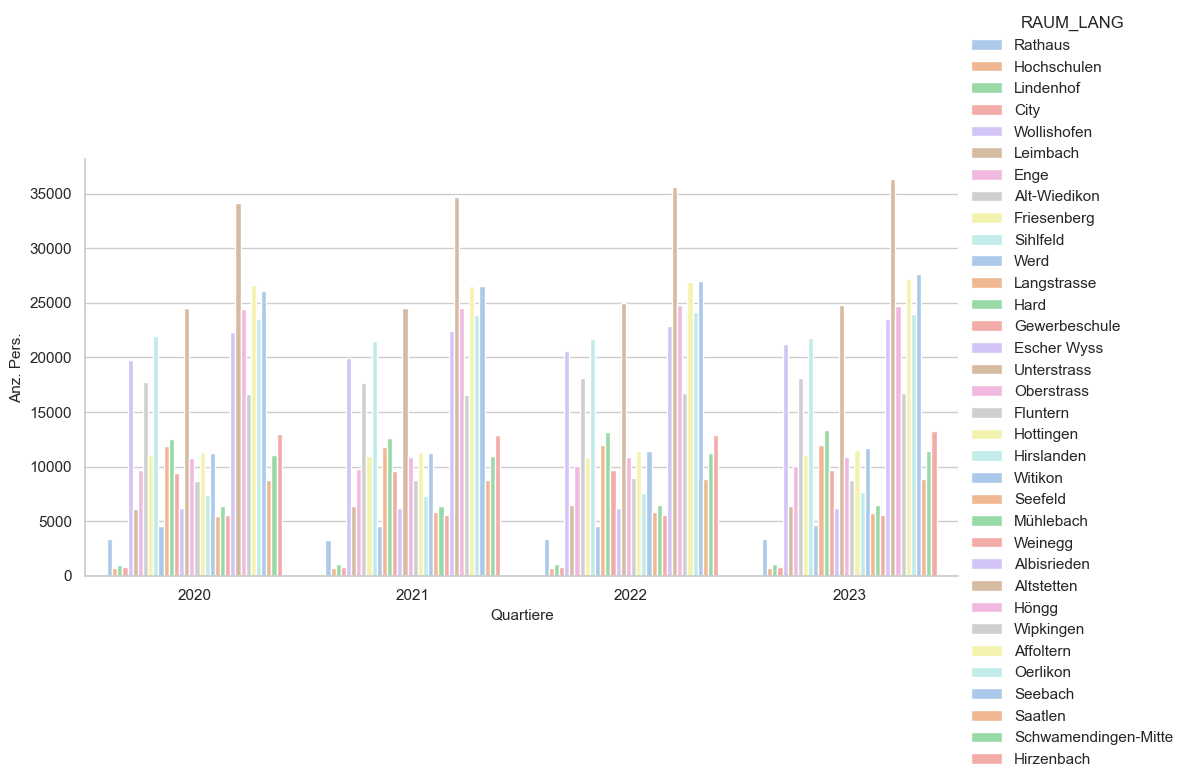

In [44]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr"
            , y="sum_WBev"
            , hue="RAUM_LANG"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index().sort_values("RAUM_CODE", ascending=True)
           )
myHist.set_xlabels('Quartiere', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


#### Faced Grids

In [45]:
myFG = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr','StichtagDatJahr_str', 'RAUM_LANG', 'RAUM_CODE', 'RAUM_my_sort']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('RAUM_my_sort', ascending=True) 

myFG

,,,,,sum_WBev
Jahr,StichtagDatJahr_str,RAUM_LANG,RAUM_CODE,RAUM_my_sort,
2013,2013-12-31,Rathaus,R00011,11,3194
2009,2009-12-31,Rathaus,R00011,11,3110
1992,1992-12-31,Rathaus,R00011,11,3094
2010,2010-12-31,Rathaus,R00011,11,3099
1930,1930-12-31,Rathaus,R00011,11,10548
...,...,...,...,...,...
2000,2000-12-31,Hirzenbach,R00123,123,11281
1981,1981-12-31,Hirzenbach,R00123,123,11610
2012,2012-12-31,Hirzenbach,R00123,123,11404


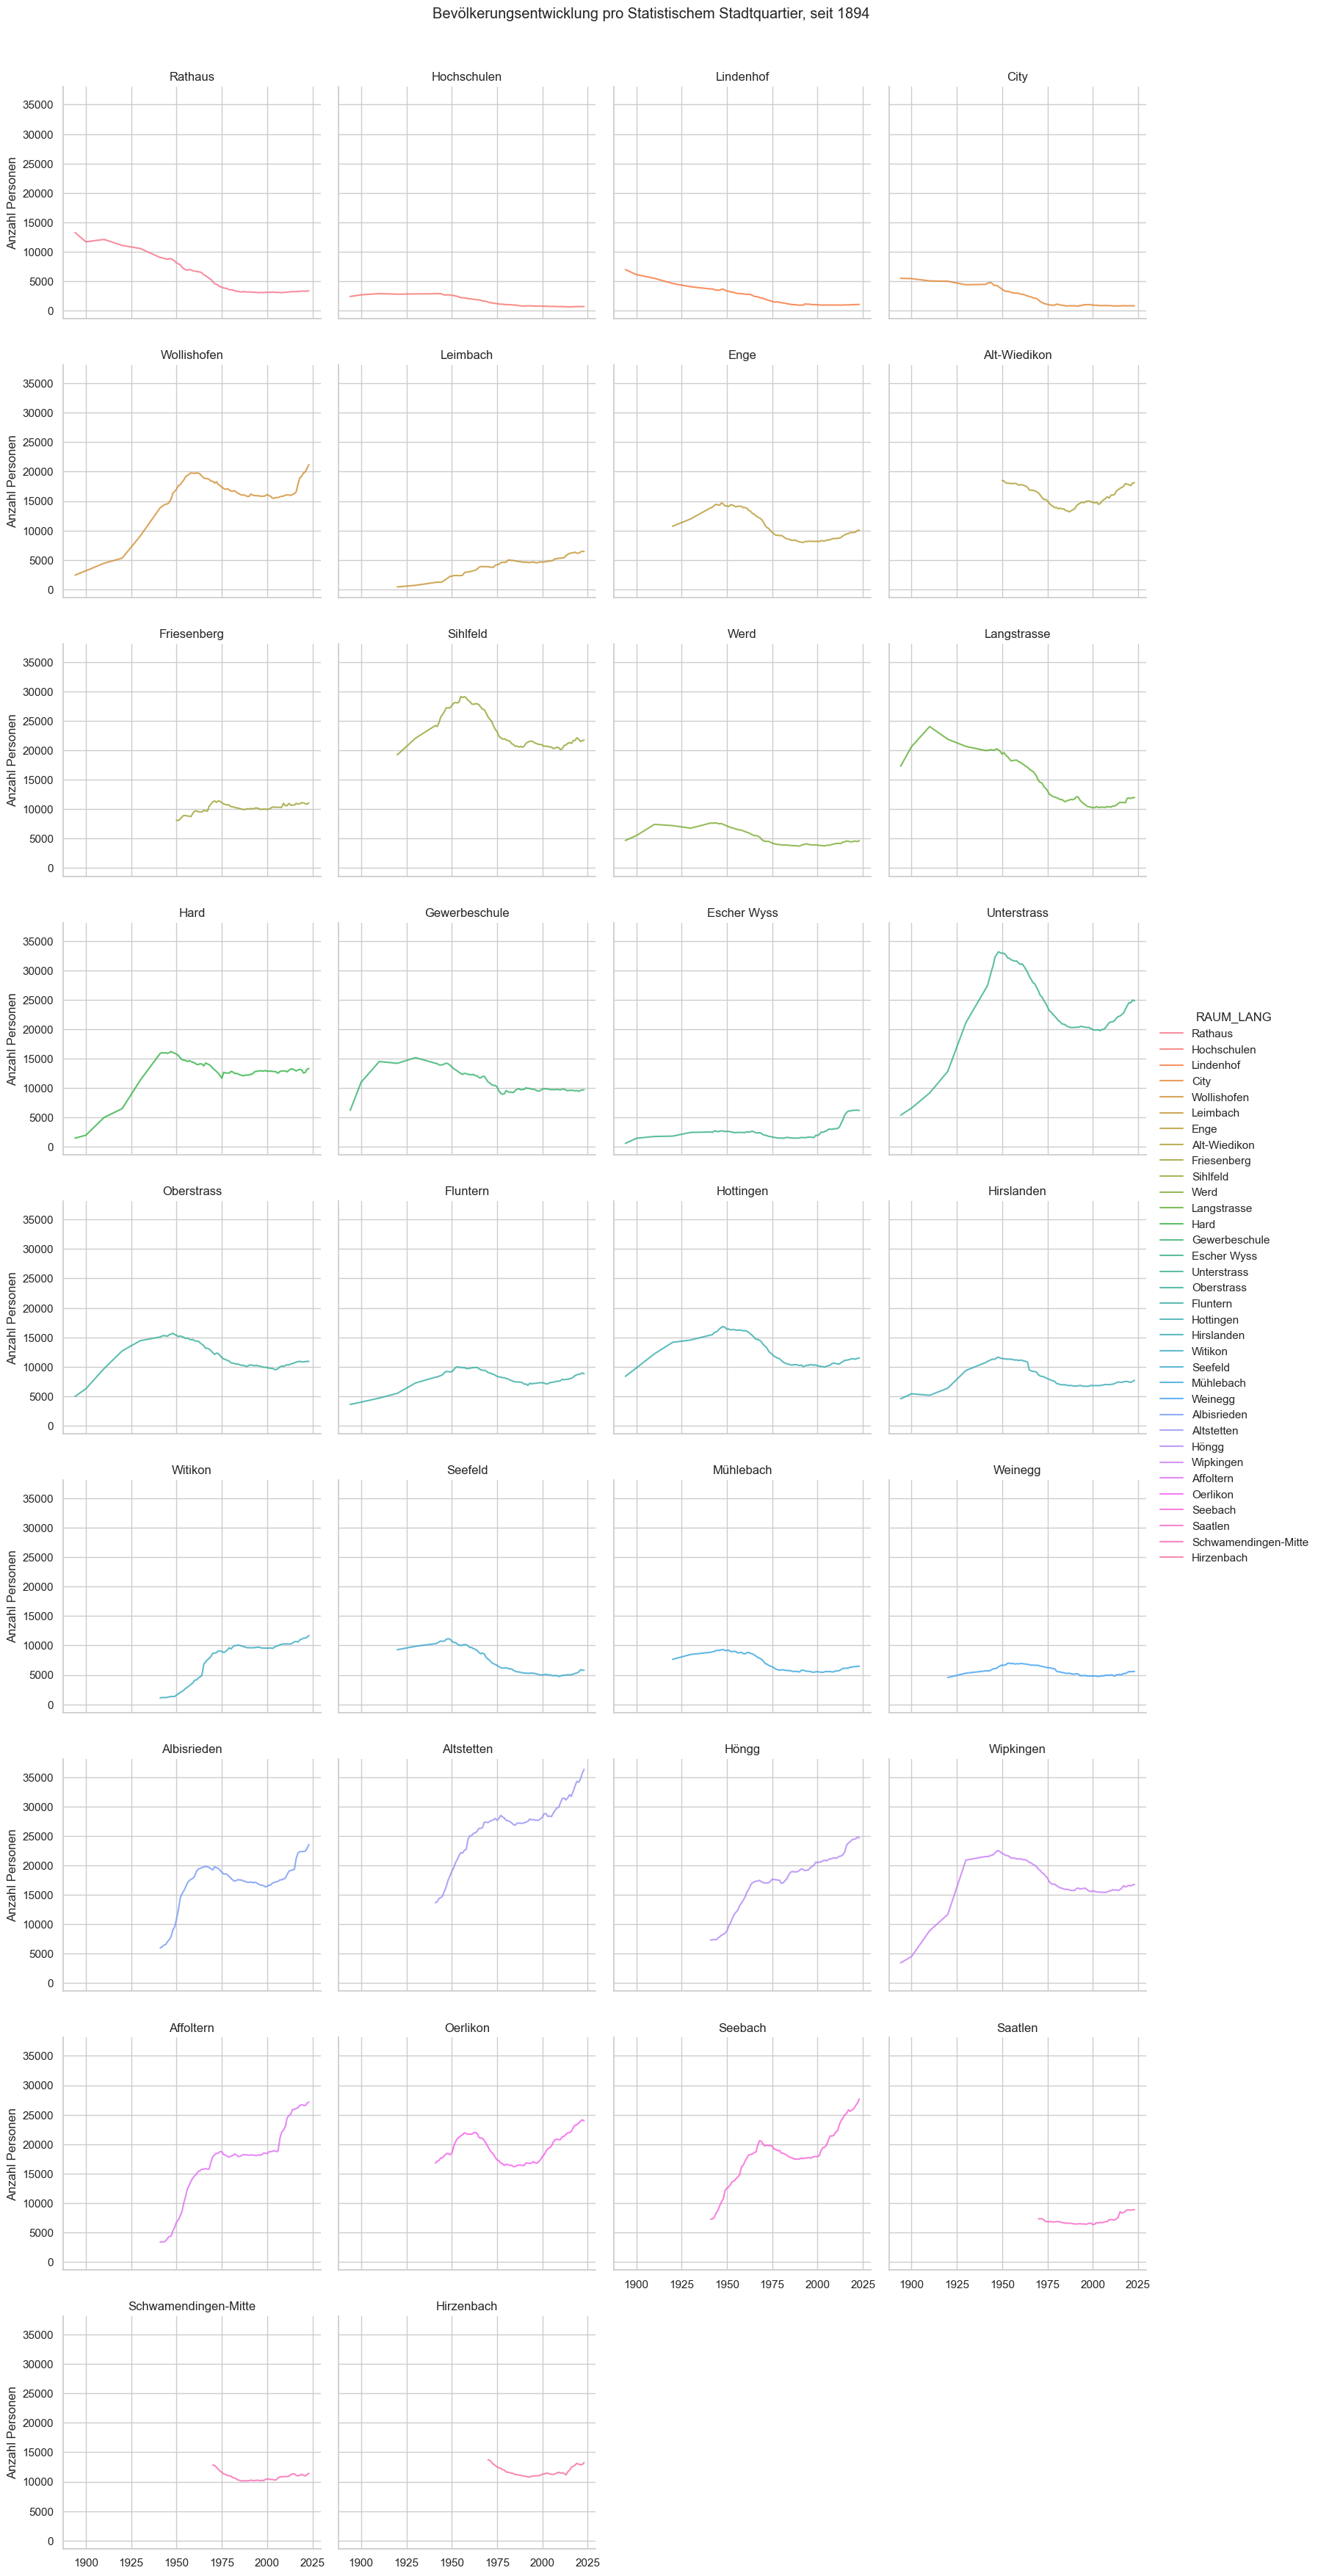

In [46]:
faced_grid1 = mypy_dv.plot_sns_facetgrid(
    data = myFG.reset_index()
    ,col = "RAUM_LANG"
    ,hue = "RAUM_LANG"
    ,col_wrap = 4
    ,height = 3
    ,grafiktyp = sns.lineplot
    ,x = "Jahr"
    ,xlabel = ''
    ,y = "sum_WBev"
    ,ylabel= "Anzahl Personen"
    ,warning_status ="ignore"
    ,myTitle="Bevölkerungsentwicklung pro Statistischem Stadtquartier, seit "+str(data2betested.index.year.min())
)
faced_grid1

In [47]:
grafic_name = package_name+"_fg_quartier_zeit_"+date_today+".png"

print('grafiken_testing/'+grafic_name)


faced_grid1.savefig('grafiken_testing/'+grafic_name)


grafiken_testing/bev324od3240_fg_quartier_zeit__2024-06-26.png


In [48]:
myFG2 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr','StichtagDatJahr_str', 'KREISEZH_LANG', 'KREISEZH_CODE', 'RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('KREISEZH_CODE', ascending=True) 

myFG2

sum_WBev
Jahr StichtagDatJahr_str KREISEZH_LANG                  KREISEZH_CODE RAUM_LANG   RAUM_CODE          
2003 2003-12-31          Kreis 2 (ab 1893)              R00200        Wollishofen R00021        15468
1974 1974-12-31          Kreis 2 (ab 1893)              R00200        Enge        R00024         9971
                                                                      Leimbach    R00023         4085
                                                                      Wollishofen R00021        17650
1975 1975-12-31          Kreis 2 (ab 1893)              R00200        Enge        R00024         9672
...                                                                                               ...
1992 1992-12-31          Kreis 1 (Stadtgebiet vor 1893) R10000        Hochschulen R00012          803
                                                                      City        R00014          744
1970 1970-12-31          Kreis 1 (Stadtgebiet vor 1893) R10000        City        R00014         1820
2016 2016-12-31          Kreis 1 (Stadtgebiet vor 1893) R10000        Hochschulen R00012          640
1894 1894-12-31          Kreis 1 (Stadtgebiet vor 1893) R10000        City        R00014         5479

[2809 rows x 1 columns]

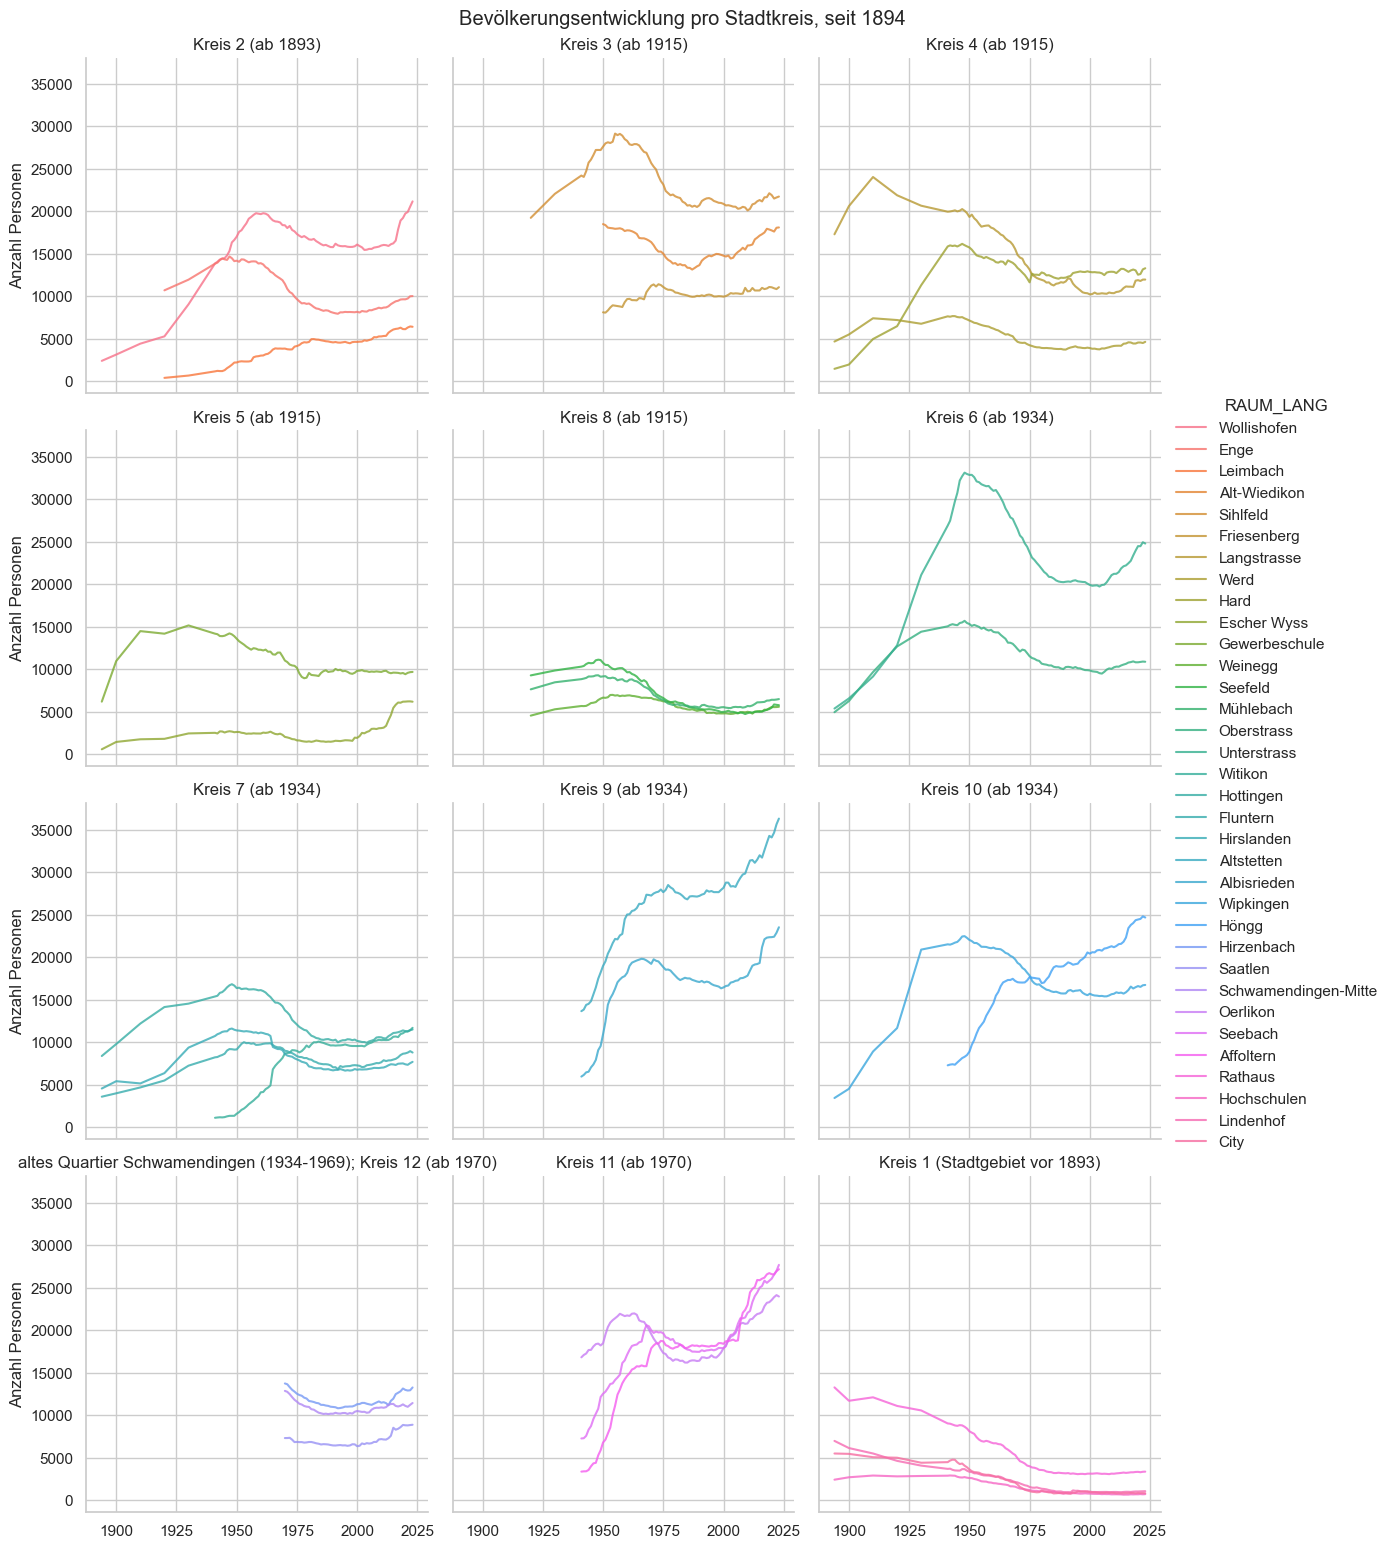

In [49]:
faced_grid2 = mypy_dv.plot_sns_facetgrid(
    data = myFG2.reset_index()
    ,col = "KREISEZH_LANG"
    ,hue = "RAUM_LANG"
    ,col_wrap = 3
    ,height = 4
    ,grafiktyp = sns.lineplot
    ,x = "Jahr"
    ,xlabel = ''
    ,y = "sum_WBev"
    ,ylabel= "Anzahl Personen"
    ,warning_status ="ignore"
    ,myTitle="Bevölkerungsentwicklung pro Stadtkreis, seit "+str(data2betested.index.year.min())
)
faced_grid2

In [50]:
grafic_name = package_name+"_fg_Kreis_quartier_zeit_"+date_today+".png"

print('grafiken_testing/'+grafic_name)


faced_grid2.savefig('grafiken_testing/'+grafic_name)


grafiken_testing/bev324od3240_fg_Kreis_quartier_zeit__2024-06-26.png


## ---------------------- hier Plausi beendet

Übersicht zu LOSD-Jobs:
[Sharepoint](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/OGD%20Metadaten.aspx#InplviewHasheb69a2c0-ed94-4ef2-91a5-3b19f038e442=FilterField1%3DMetadaten%255Fx002d%255FPublikations%255Fx00-FilterValue1%3DINT)